# Ch12: Unsupervised Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

%matplotlib inline

In [2]:
from ISLP import load_data
from ISLP.cluster import compute_linkage
from scipy.cluster.hierarchy import cut_tree, dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from statsmodels.datasets import get_rdataset


## Conceptual

### **Q1.**


**(a)** To prove $(12.18)$:

$$
\frac{1}{ |C_k| } \sum_{i, i' \in C_k} \sum^p_{j = 1} (x_{ij} - x_{i'j})^2 = 2 \sum_{i\in C_k} \sum^p_{j = 1} (x_{ij} - \bar x_{kj})^2
$$

We'll start by adding and subtracting $\bar x_{kj}$ on the LHS:

$$
\frac{1}{ |C_k| } \sum_{i, i' \in C_k} \sum^p_{j = 1} (x_{ij} - \bar x_{kj} + \bar x_{kj} - x_{i'j})^2
$$


Then we'll rearrange them and expand the squared difference like so:

$$
\frac{1}{ |C_k| } \sum_{i, i' \in C_k} \sum^p_{j = 1} ((x_{ij} - \bar x_{kj}) - (x_{i'j}- \bar x_{kj}))^2
$$

$$
\frac{1}{ |C_k| } \sum_{i, i' \in C_k} \sum^p_{j = 1} \left( (x_{ij} - \bar x_{kj})^2 - 2(x_{ij} - \bar x_{kj})(x_{i'j}- \bar x_{kj}) + (x_{i'j}- \bar x_{kj})^2 \right)
$$



We can break up the sum over $i$ and $i'$ into two different sums and apply them on each term here

$$
 \sum^p_{j = 1} \left(\frac{1}{ |C_k| } \sum_{i \in C_k} \sum_{i' \in C_k} (x_{ij} - \bar x_{kj})^2 - \frac{2}{ |C_k| } \sum_{i \in C_k} \sum_{i' \in C_k} (x_{ij} - \bar x_{kj})(x_{i'j}- \bar x_{kj}) + \frac{1}{ |C_k| } \sum_{i \in C_k} \sum_{i' \in C_k} (x_{i'j}- \bar x_{kj})^2 \right) \qquad (1)
$$

For the first term we can see that $(x_{ij} - \bar x_{kj})^2$ doesn't depend on $i'$ so the sum over $i'$ is basically adding up the same value $|C_k|$ times:

$$
\frac{1}{ |C_k| } \sum_{i \in C_k} \sum_{i' \in C_k} (x_{ij} - \bar x_{kj})^2 = \frac{1}{ |C_k| } \sum_{i \in C_k} |C_k| (x_{ij} - \bar x_{kj})^2 = \sum_{i \in C_k}  (x_{ij} - \bar x_{kj})^2
$$

The same applies to the last term:

$$
\frac{1}{ |C_k| } \sum_{i \in C_k} \sum_{i' \in C_k} (x_{i'j} - \bar x_{kj})^2 = \frac{1}{ |C_k| } \sum_{i' \in C_k} |C_k| (x_{i'j} - \bar x_{kj})^2 = \sum_{i' \in C_k}  (x_{i'j} - \bar x_{kj})^2
$$


As for the second term

$$
\frac{2}{ |C_k| } \sum_{i \in C_k} \sum_{i' \in C_k} (x_{ij} - \bar x_{kj})(x_{i'j}- \bar x_{kj})
$$

We can write this as a product of two sums as each sum's terms don't depend on the other's:

$$
\frac{2}{ |C_k| } \sum_{i \in C_k} (x_{ij} - \bar x_{kj}) \sum_{i' \in C_k} (x_{i'j}- \bar x_{kj})
$$

Using the definition of $\bar x_{kj} = \frac{1}{ |C_k| } \sum_{i \in C_k} x_{ij}$ the quantity above evaluates to $0$:

Substituting back into equation $(1)$ we get:

$$
 \sum^p_{j = 1} \left( \sum_{i \in C_k}  (x_{ij} - \bar x_{kj})^2 - 0 + \sum_{i' \in C_k}  (x_{i'j} - \bar x_{kj})^2 \right)
$$

We can see that the two sums are equivalent and can be rewritten as:

$$
2 \sum^p_{j = 1} \sum_{i \in C_k} (x_{ij} - \bar x_{kj})^2  
$$

Which is equivalent to the RHS of the equation we set out to prove.

**(b)**

We'll start by substituting $(12.18)$ into the objective function $(12.17)$:

$$
\underset{C_1,...,C_k}{\operatorname{minimize}} \left\{ 2 \sum_{k = 1}^K \sum^p_{j = 1} \sum_{i \in C_k} (x_{ij} - \bar x_{kj})^2   \right\}
$$

This is the **total within-cluster sum of squared Euclidean distances** from each point to its cluster's centroid (multiplied by $2$).

Since this is a two step algorithm we can prove that the objective is non-increasing if we prove that each step of the algorithm is non-increasing.

Starting with step $2(a)$:

"For each of the $K$ clusters, compute the cluster centroid. The
$k\text{th}$ cluster centroid is the vector of the $p$ feature means for the
observations in the $k\text{th}$ cluster."

The cluster's centroid is the point which minimizes the sum of Euclidean distances to a set of a set of points in that cluster. By calculating the cluster's centroid, step $2(a)$ is explicitly choosing the exact centroid that minimizes the within-cluster sum of squares for the current assignments. \
Therfore this step can only decrease the value of the objective function or leave it unchanged, hence this step is **non-increasing**. 

Now for step $2(b)$:

"Assign each observation to the cluster whose centroid is closest
(where closest is defined using Euclidean distance)."
In this step, centroids are held fixed, and the algorithm reassigns each observation $x_i$ to the cluster with the nearest centroid.

For a fixed set of centroids, we want to assign each point $x_i$ to a cluster to minimize the objective function above.

The contribution of a single point $x_i$ currently in cluster $C_k$ to the total objective is $2 \sum^p_{j = 1} (x_{ij} - \bar x_{kj})^2$, which is just twice its squared Euclidean distance to it centroid. To minimize the total sum, we must minimize each term in the sum. The algorithm reassigns $x_i$ to the cluster $C_{k^*}$ that minimizes this exact quantity.

So if a point is moved to a new cluster, it is because its contribution to the objective function is smaller in the new cluster. If it isn't moved it is already in the best possible cluster for the current centroids. \
Therefore by definition this step is also **non-increasing**.

Since both steps $2(a)$ and $2(b)$ are **non-increasing** the algorithm $(12.2)$ is **non-increasing**.

### **Q2.**


The dissimilarity matrix is given by:

$$
\left[
\begin{matrix}
 & 0.3 & 0.4 & 0.7  \\
0.3 &  & 0.5 & 0.8  \\
0.4 & 0.5 &  & 0.45 \\
0.7 & 0.8 & 0.45 &  \\
\end{matrix}
\right]
$$

**(a)** 
- $\{1\}$ and $\{2\}$ fuse at height $0.3$.
- $\{3\}$ and $\{4\}$ fuse at height $0.45$.
- $\{1,2\}$ and $\{3,4\}$ fuse at height $0.8$.

In [3]:
# This function was vibe coded with Grok
import re


def draw_dendrogram(fusions, leaf_labels):
    """
    Manually draw a dendrogram based on fusion information, with dashed lines from the left edge to the merging point at each fusion height.

    Parameters:
    fusions: List of tuples (cluster1, cluster2, height) describing merges.
    leaf_labels: List of labels for the leaf nodes (e.g., ['1', '2', '3', '4']).
    """
    # Initialize figure with XKCD style
    with plt.xkcd():
        plt.figure(figsize=(8, 6))
        plt.rcParams["font.family"] = "DejaVu Sans"

        # Assign x-positions to leaves (evenly spaced)
        n_leaves = len(leaf_labels)
        x_positions = {str(i): idx for idx, i in enumerate(leaf_labels)}
        cluster_positions = x_positions.copy()  # Tracks current x-position of clusters
        cluster_heights = {str(i): 0 for i in leaf_labels}  # Tracks height of clusters

        def get_leaf_nodes(cluster):
            """Extract all leaf nodes from a cluster label (e.g., '(1,2,3)' -> ['1', '2', '3'])."""
            if cluster in leaf_labels:
                return [cluster]
            # Remove parentheses and split by comma
            cleaned = cluster.strip("()")
            return re.split(r",\s*", cleaned)

        # Process each fusion
        for cluster1, cluster2, height in fusions:
            # Get leaf nodes for each cluster
            leaves1 = get_leaf_nodes(str(cluster1))
            leaves2 = get_leaf_nodes(str(cluster2))

            # Calculate x-positions as average of leaf positions
            x1 = sum(x_positions[leaf] for leaf in leaves1) / len(leaves1)
            x2 = sum(x_positions[leaf] for leaf in leaves2) / len(leaves2)

            # Draw vertical lines from current height to fusion height
            plt.plot([x1, x1], [cluster_heights[str(cluster1)], height], "b-")
            plt.plot([x2, x2], [cluster_heights[str(cluster2)], height], "b-")

            # Draw horizontal line connecting the clusters at fusion height
            plt.plot([x1, x2], [height, height], "b-")

            # Draw dashed line from left edge to merging point
            x_left = min(x1, x2)
            x_merge = (x1 + x2) / 2
            plt.plot([-0.25, x_merge], [height, height], "r--")

            # Annotate the fusion height near the merging point
            plt.text(-0.25, height, f"h={height}", va="bottom", ha="center", color="r")

            # Update cluster information: new cluster at midpoint
            new_cluster = f"({','.join(leaves1 + leaves2)})"
            cluster_positions[new_cluster] = (x1 + x2) / 2
            cluster_heights[new_cluster] = height

            # Remove old clusters from positions and heights
            del cluster_positions[str(cluster1)]
            del cluster_positions[str(cluster2)]
            del cluster_heights[str(cluster1)]
            del cluster_heights[str(cluster2)]

        # Plot leaf labels
        for label, x in x_positions.items():
            plt.text(x, -0.05, label, ha="center", va="top")

        # Set plot attributes
        plt.xlabel("Clusters")
        plt.ylabel("Height")
        plt.title("Dendrogram")
        plt.xticks([])  # Hide x-axis ticks
        plt.show()

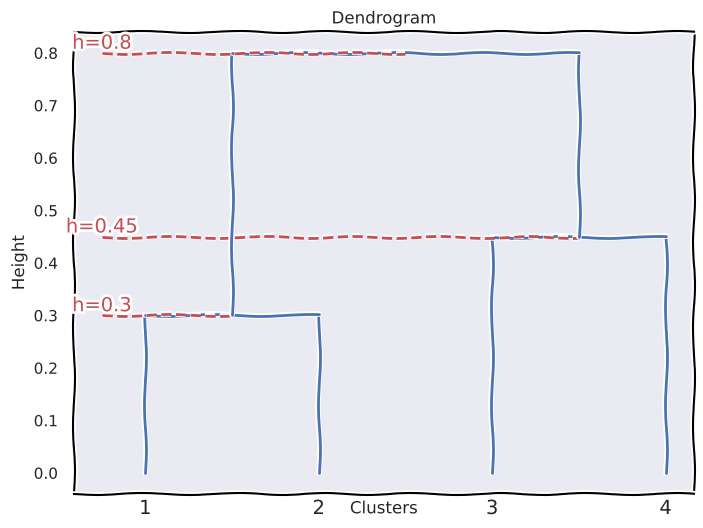

In [4]:
fusions = [
    (1, 2, 0.3),  # 1 and 2 fuse at height 0.3
    (3, 4, 0.45),  # 3 and 4 fuse at height 0.45
    ("(1,2)", "(3,4)", 0.8),  # {1,2} and {3,4} fuse at height 0.8
]

leaf_labels = ["1", "2", "3", "4"]
draw_dendrogram(fusions, leaf_labels)

**(b)**
- $\{1\}$ and $\{2\}$ fuse at height $0.3$.
- The cluster $\{1, 2\}$ fuses with $\{3\}$ at height $0.4$.
- The cluster $\{1, 2, 3\}$ fuses with $\{4\}$ at height $0.45$.

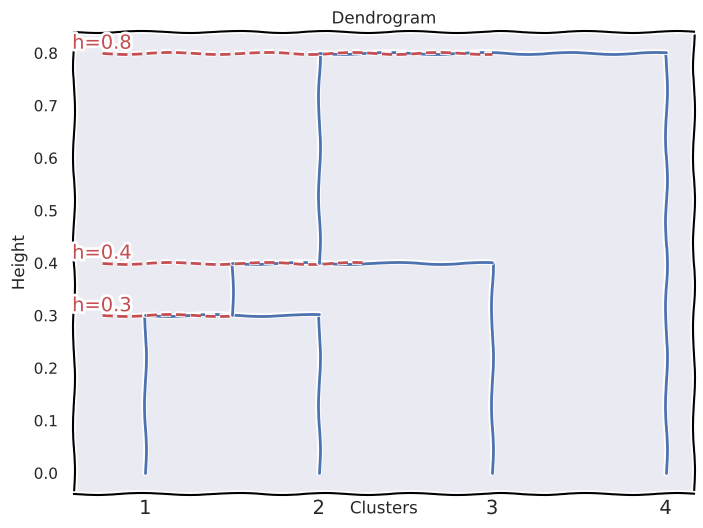

In [5]:
fusions = [
    (1, 2, 0.3),  # {1} and {2} fuse at height 0.3
    ("(1,2)", 3, 0.4),  # {1,2} and {3} fuse at height 0.4
    ("(1,2,3)", 4, 0.8),  # {1,2,3} and {4} fuse at height 0.45
]

leaf_labels = ["1", "2", "3", "4"]
draw_dendrogram(fusions, leaf_labels)

**(c)**
The resulting clusters would be $\{1, 2\}$ and $\{3, 4\}$.

**(d)** The resulting clusters would be $\{1, 2, 3\}$ and $\{4\}$.

**(e)** By repositioning some of the leaves we can obtain an equivalent dendrogram that looks slightly different than the one drawn in **(a)**.

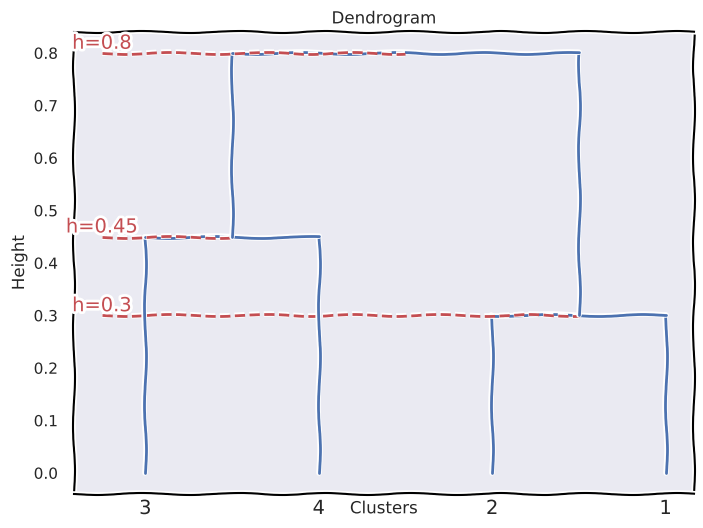

In [6]:
fusions = [
    (1, 2, 0.3),  # 1 and 2 fuse at height 0.3
    (3, 4, 0.45),  # 3 and 4 fuse at height 0.45
    ("(3,4)", "(1,2)", 0.8),  # {1,2} and {3,4} fuse at height 0.8
]

leaf_labels = ["3", "4", "2", "1"]
draw_dendrogram(fusions, leaf_labels)

### **Q3.**


In [7]:
X = np.array([[1, 1, 0, 5, 6, 4], [4, 3, 4, 1, 2, 0]])
X[0], X[1]

(array([1, 1, 0, 5, 6, 4]), array([4, 3, 4, 1, 2, 0]))

**(a)**

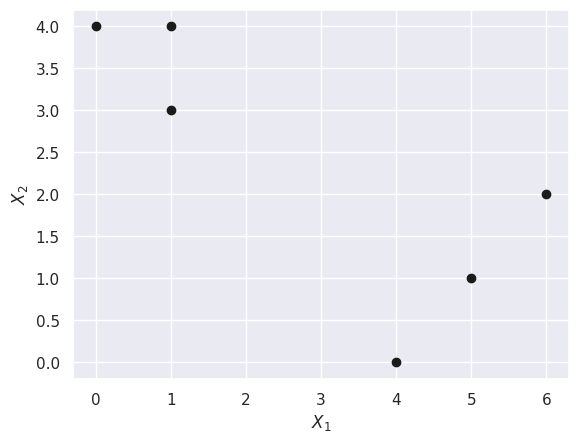

In [8]:
plt.scatter(X[0], X[1], c="k")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$");

**(b)**

In [9]:
rng = np.random.default_rng(42)
init_rand_clusters = rng.choice(np.arange(2), 6)
init_rand_clusters

array([0, 1, 1, 0, 0, 1])

In [10]:
clust1 = init_rand_clusters == 0
clust2 = init_rand_clusters == 1
X[:, clust1]

array([[1, 5, 6],
       [4, 1, 2]])

In [11]:
X[:, clust2]

array([[1, 0, 4],
       [3, 4, 0]])

**(c)**


In [12]:
def centroid(cluster):
    return np.mean(X[:, cluster], axis=1)

In [13]:
c1 = centroid(clust1)
c1

array([4.        , 2.33333333])

In [14]:
c2 = centroid(clust2)
c2

array([1.66666667, 2.33333333])

I'll also plot the centroids of these random clusters to make sure they make sense.

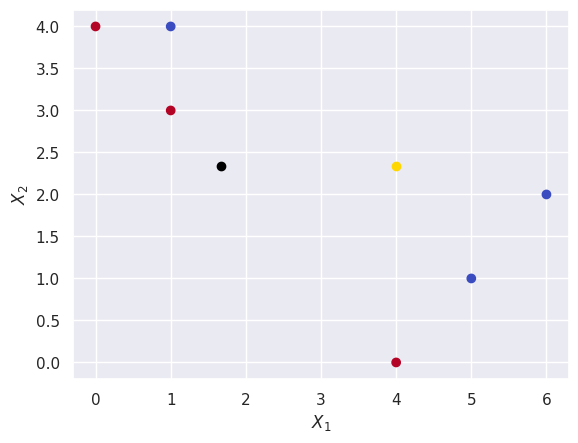

In [15]:
plt.scatter(X[0], X[1], c=init_rand_clusters, cmap=plt.cm.coolwarm)
plt.scatter(*centroid(clust1), c="gold")
plt.scatter(*centroid(clust2), c="black")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$");

**(d)** 


In [16]:
cluster_labels = np.zeros_like(init_rand_clusters)
for i, obs in enumerate(X.T):
    dist_to_c1 = np.linalg.norm(c1 - obs)
    dist_to_c2 = np.linalg.norm(c2 - obs)

    if dist_to_c1 <= dist_to_c2:
        cluster_labels[i] = 0
    else:
        cluster_labels[i] = 1

In [17]:
for i, label in enumerate(cluster_labels):
    print(f"Obs. {i}: {label}")

Obs. 0: 1
Obs. 1: 1
Obs. 2: 1
Obs. 3: 0
Obs. 4: 0
Obs. 5: 0


**(e)** Putting steps $(c)$ and $(d)$ into one step and looping until the clusters stop changing:

In [18]:
while True:
    old_cluster_labels = cluster_labels.copy()

    clust1 = cluster_labels == 0
    clust2 = cluster_labels == 1
    c1 = centroid(clust1)
    c2 = centroid(clust2)

    cluster_labels = np.zeros_like(init_rand_clusters)
    for i, obs in enumerate(X.T):
        dist_to_c1 = np.linalg.norm(c1 - obs)
        dist_to_c2 = np.linalg.norm(c2 - obs)

        if dist_to_c1 <= dist_to_c2:
            cluster_labels[i] = 0
        else:
            cluster_labels[i] = 1

    if np.array_equal(cluster_labels, old_cluster_labels):
        print("The clusters stopped changing")
        break

The clusters stopped changing


In [19]:
cluster_labels

array([1, 1, 1, 0, 0, 0])

**(f)**

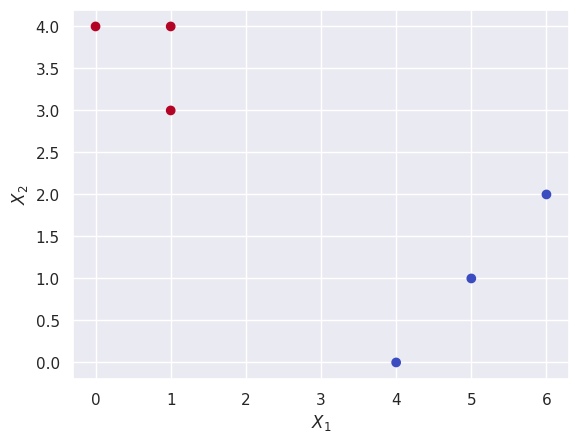

In [20]:
plt.scatter(X[0], X[1], c=cluster_labels, cmap=plt.cm.coolwarm)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$");

### **Q4.**

**(a)** They could have fused at the same height if the single linkage and complete linkage values between the two clusters were equal, in the case where the dissimilarity between the elements is the same. Or they could have fused higher in the complete linkage case, if the dissimilarities between the elements aren't all equal. So **the complete linkage fusion will occur at a height greater than or equal** to the single linkage fusion.


**(b)** The fusion will happen at the same height, since the linkage for clusters with only one element is irrelevant and the fusion is only determined by the dissimilarity between those two elements in each cluster. 

### **Q5.**

![Figure 12.16](./images/figure12_16.png)

Starting with the scale on the left, since the $y$-axis here corresponds to the number of items bought, the socks would drive the clustering procedure and people who bought more socks would end up in the same cluster, and those who bought less end up in the other cluster.

Moving on to the scale in the middle, which scales both variables using their standard deviation, here both variables contribute equally to the clustering procedure resulting in more balanced clusters that take into account both variables.

And with the scale on the right (which uses dollars spent by each online shopper on the $y$-axis), since computers are much more expensive than socks, they'd drive the clustering procedure and we would end up with $2$ clusters, those who bought a computer and those who didn't.

### **Q6.**

Starting with $(12.5)$ and $(12.6)$:

$$
x_{ij} \approx \sum_{m=1}^{M} z_{im}\phi_{jm} \qquad (12.5)
$$

$$
\underset{\mathbf{A} \in \mathbb{R}^{n \times M}, \mathbf{B} \in \mathbb{R}^{p \times M}}{\operatorname{minimize}} \left\{ \sum_{j=1}^{p} \sum_{i=1}^{n} \left( x_{ij} - \sum_{m=1}^{M} a_{im}b_{jm} \right)^2 \right\} \qquad (12.6)
$$

Substituting $(12.5)$ into the optimization problem $(12.6)$ since the quantity we're trying to minimize is the squared approximation error between the original matrix and our inferred matrix:

$$
\underset{\mathbf{Z} \in \mathbb{R}^{n \times M}, \mathbf{\Phi} \in \mathbb{R}^{p \times M}}{\operatorname{minimize}} \left\{ \sum_{j=1}^{p} \sum_{i=1}^{n} \left( x_{ij} - \sum_{m=1}^{M} z_{im}\phi_{jm} \right)^2 \right\}
$$

Since the score vectors $z_{im}$ are known we don't have to treat them as variables here and there's no need to minimize over them:

$$
\underset{\mathbf{\Phi} \in \mathbb{R}^{p \times M}}{\operatorname{minimize}} \left\{ \sum_{j=1}^{p} \sum_{i=1}^{n} \left( x_{ij} - \sum_{m=1}^{M} z_{im}\phi_{jm} \right)^2 \right\}
$$

Now switching the two summations around we get:

$$
\underset{\mathbf{\Phi} \in \mathbb{R}^{p \times M}}{\operatorname{minimize}} \left\{ \sum_{i=1}^{n} \sum_{j=1}^{p} \left( x_{ij} - \sum_{m=1}^{M} z_{im}\phi_{jm} \right)^2 \right\}
$$ 

And analyzing the summation for the value of $j = 1$ for example:

$$
\underset{\mathbf{\Phi} \in \mathbb{R}^{p \times M}}{\operatorname{minimize}} \left\{ \sum_{i=1}^{n} \left( x_{i1} - \sum_{m=1}^{M} z_{im}\phi_{1m} \right)^2 \right\}
$$ 

The formula above looks familiar, let's recall the formula for linear regression

$$
\underset{\beta_0, \beta_1, ..., \beta_K}{\operatorname{minimize}} \left\{ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{k=1}^{K} \beta_k x_i  \right)^2 \right\}
$$ 

 We can see that this minimization problem maps perfectly to a linear regression problem like so:
- $x_{ij}$ (the values of the original matrix) maps to $y_{i}$ which is the response.
- The regression coefficients $\beta_k$ map to the principal component loading vectors $\phi_{jm}$. 
- The score vectors $z_m$ map to the predictor variable $x_i$.
- The intercept $\beta_0 = 0$ in this case. 

And it has the loadings $\phi_{11}, \phi_{12}, ...,\phi_{1M}$ as its coefficients, and the same applies for values $j = 1, 2, ..., p$

Since the loadings for each minimization problem given a value of $j$ don't depend on each other, we can think of this as $p$ separate and independent least square linear regressions.

#### Extra: 
I know the question is conceptual but I was interested in seeing it work, so I tried fitting the `p` linear regressions of `scores` onto each of the features in the `USArrests` dataset.

In [21]:
X = get_rdataset("USArrests").data
X.shape

(50, 4)

In [22]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
scores = pca.fit_transform(X_scaled)
scores.shape

(50, 4)

In [23]:
Xshape = X_scaled.shape
components = np.zeros((Xshape[1], Xshape[1]))
for p in range(Xshape[1]):
    predictors = scores
    response = X_scaled[:, p]
    
    lr = LinearRegression()
    lr.fit(predictors, response)
    components[p] = lr.coef_

In [24]:
components.T

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

In [25]:
pca.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

We can see the linear regression coefficients obtained and the PCA components are exactly the same.

In [26]:
np.allclose(components.T, pca.components_)

True

In [27]:
np.allclose(scores @ components.T, X_scaled)

True

## Applied

### **Q7.** 


Show that:

$$
d_{ij}^2 \propto 1 - r_{ij} \\
$$

$$
d_{ij}^2 = k  (1 - r_{ij}) 
$$

Where $r_{ij}$ and $d_{ij}$ are the correlation and euclidean distance between the $i\text{th}$ and $j\text{th}$ observations respectively and k is the proportionality constant.

In [28]:
USArrests = get_rdataset("USArrests").data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


To scale the data so that each observation has zero mean and unit std, we'll use `StandardScaler` but transpose the matrix before and after the scaling.

In [29]:
scaler = StandardScaler()
USArrests_scaled = scaler.fit_transform(USArrests.T).T

In [30]:
USArrests_scaled.mean(), USArrests_scaled.std()

(0.0, 1.0)

We'll calculate $(d_{ij})^2$ here:

In [31]:
squared_euclidean_distances = pairwise_distances(USArrests_scaled) ** 2
squared_euclidean_distances[:5, :5]

array([[0.        , 0.07259981, 0.01144126, 0.00304652, 0.04949639],
       [0.07259981, 0.        , 0.08243033, 0.0747504 , 0.12923057],
       [0.01144126, 0.08243033, 0.        , 0.00268103, 0.01355458],
       [0.00304652, 0.0747504 , 0.00268103, 0.        , 0.02811048],
       [0.04949639, 0.12923057, 0.01355458, 0.02811048, 0.        ]])

And $1 - r_{ij}$:

In [32]:
corr_dissimilarity = 1 - np.corrcoef(USArrests_scaled)
corr_dissimilarity[corr_dissimilarity == 0] = (
    0.0000000001  # this line is to prevent zero divison errors
)
corr_dissimilarity[:5,:5]

array([[2.22044605e-16, 9.07497591e-03, 1.43015785e-03, 3.80814469e-04,
        6.18704925e-03],
       [9.07497591e-03, 2.22044605e-16, 1.03037911e-02, 9.34380057e-03,
        1.61538219e-02],
       [1.43015785e-03, 1.03037911e-02, 2.22044605e-16, 3.35128857e-04,
        1.69432204e-03],
       [3.80814469e-04, 9.34380057e-03, 3.35128857e-04, 2.22044605e-16,
        3.51381016e-03],
       [6.18704925e-03, 1.61538219e-02, 1.69432204e-03, 3.51381016e-03,
        1.00000000e-10]])

Now to find $k$ the proportionality constant we'll do element-wise division on the two:

$$
k = \frac{d_{ij}^2}{1 - r_{ij}}
$$

In [33]:
np.divide(squared_euclidean_distances, corr_dissimilarity)[:5,:5]

array([[0., 8., 8., 8., 8.],
       [8., 0., 8., 8., 8.],
       [8., 8., 0., 8., 8.],
       [8., 8., 8., 0., 8.],
       [8., 8., 8., 8., 0.]])

We can see that all off-diagonal elements are $8$ which means the value of the proportionality constant $k = 8$.

You can show mathematically that $k = 2p$ (where $p$ is the number of features) but the question doesn't ask for it here.

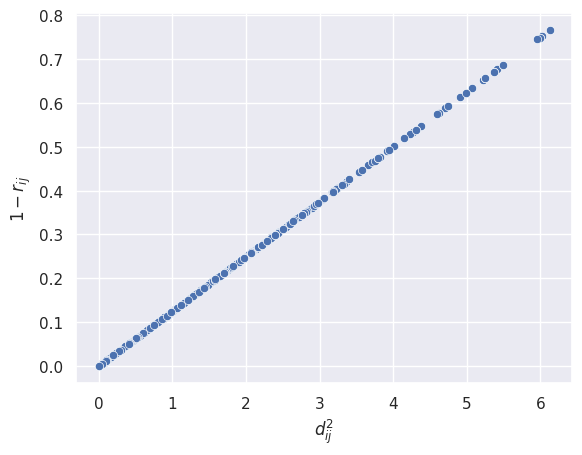

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=squared_euclidean_distances.flatten(), y=corr_dissimilarity.flatten(), ax=ax
)
ax.set_xlabel("$d_{ij}^2$")
ax.set_ylabel("$1 - r_{ij}$");

### **Q8.** 


In [35]:
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Scaling the data first:

In [36]:
scaler = StandardScaler()
USArrests_scaled = scaler.fit_transform(USArrests)
USArrests_scaled.mean(), USArrests_scaled.std()

(1.021405182655144e-16, 1.0)

**(a)** Using the `explained_variance_ratio_` attribute of `PCA`:

In [37]:
pca = PCA()
pca.fit(USArrests_scaled)
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

**(b)** Using the equation:

$$
\frac{\sum_{i=1}^{n} z_{im}^2}{\sum_{j=1}^{p} \sum_{i=1}^{n} x_{ij}^2} = \frac{\sum_{i=1}^{n} \left( \sum_{j=1}^{p} \phi_{jm} x_{ij} \right)^2}{\sum_{j=1}^{p} \sum_{i=1}^{n} x_{ij}^2}
$$

In [38]:
loading_vectors = pca.components_
loading_vectors

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

In [39]:
np.sum(np.dot(loading_vectors, USArrests_scaled.T) ** 2, axis=1) / np.sum(
    USArrests_scaled**2
)

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

We can see that both approaches yield the same PVE values.

### **Q9.** 


In [40]:
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


**(a)**


In [41]:
hclust = AgglomerativeClustering(
    linkage="complete", metric="euclidean", n_clusters=None, distance_threshold=0
)
hclust.fit(USArrests)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

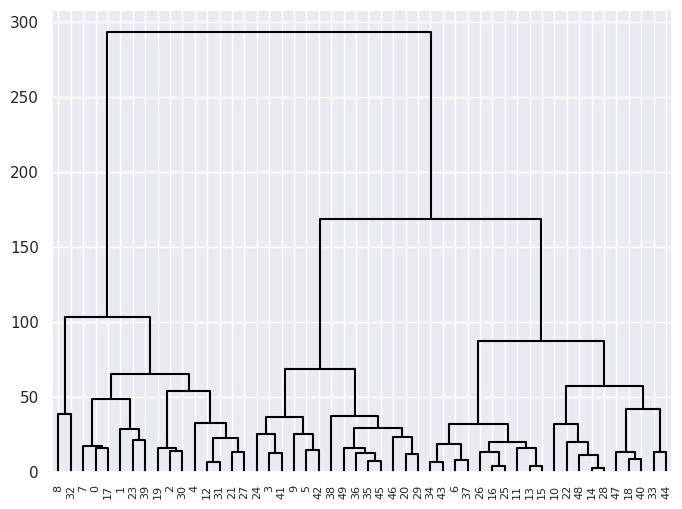

In [42]:
cargs = {"color_threshold": -np.inf, "above_threshold_color": "black"}
linkage_comp = compute_linkage(hclust)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
dendrogram(linkage_comp, ax=ax, **cargs);

**(b)** Cutting the dendrogram at height $120$ yields $3$ clusters.

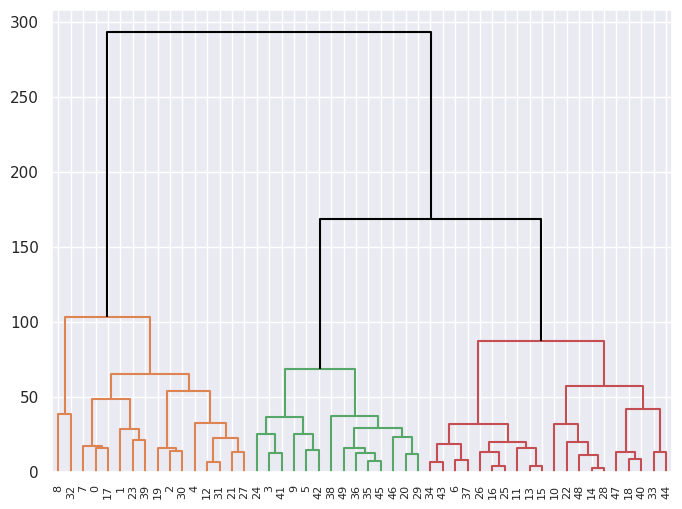

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
dendrogram(linkage_comp, ax=ax, color_threshold=120, above_threshold_color="black");


In [44]:
clustered_USArrests = USArrests.copy()
clustered_USArrests["cluster"] = cut_tree(linkage_comp, n_clusters=3).T[0]
clustered_USArrests.head()

,Murder,Assault,UrbanPop,Rape,cluster
rownames,,,,,
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,0
Arizona,8.1,294,80,31.0,0
Arkansas,8.8,190,50,19.5,1
California,9.0,276,91,40.6,0


Listing the states that belong to each cluster:

In [45]:
for cluster in [0, 1, 2]:
    print(f"Cluster: {cluster}")
    for i, state in enumerate(
        clustered_USArrests[clustered_USArrests["cluster"] == cluster].index, start=1
    ):
        if i % 6 == 0:
            print(state, end=",\n")
        else:
            print(state, end=", ")

    print("\n")

Cluster: 0
Alabama, Alaska, Arizona, California, Delaware, Florida,
Illinois, Louisiana, Maryland, Michigan, Mississippi, Nevada,
New Mexico, New York, North Carolina, South Carolina, 

Cluster: 1
Arkansas, Colorado, Georgia, Massachusetts, Missouri, New Jersey,
Oklahoma, Oregon, Rhode Island, Tennessee, Texas, Virginia,
Washington, Wyoming, 

Cluster: 2
Connecticut, Hawaii, Idaho, Indiana, Iowa, Kansas,
Kentucky, Maine, Minnesota, Montana, Nebraska, New Hampshire,
North Dakota, Ohio, Pennsylvania, South Dakota, Utah, Vermont,
West Virginia, Wisconsin, 



**(c)** Scaling the variables:

In [46]:
scaler = StandardScaler(with_mean=True, with_std=True)
USArrests_scaled = scaler.fit_transform(USArrests)
USArrests_scaled.mean(), USArrests_scaled.std()

(1.021405182655144e-16, 1.0)

In [47]:
hclust_scaled = AgglomerativeClustering(
    linkage="complete", metric="euclidean", n_clusters=None, distance_threshold=0
)
hclust_scaled.fit(USArrests_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

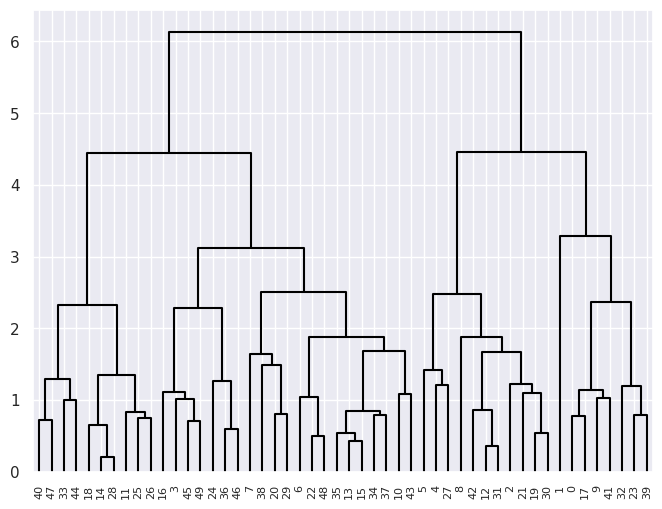

In [48]:
cargs = {"color_threshold": -np.inf, "above_threshold_color": "black"}
linkage_comp_scaled = compute_linkage(hclust_scaled)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
dendrogram(linkage_comp_scaled, ax=ax, **cargs);

Plotting the 3 cluster cuts for each side by side:

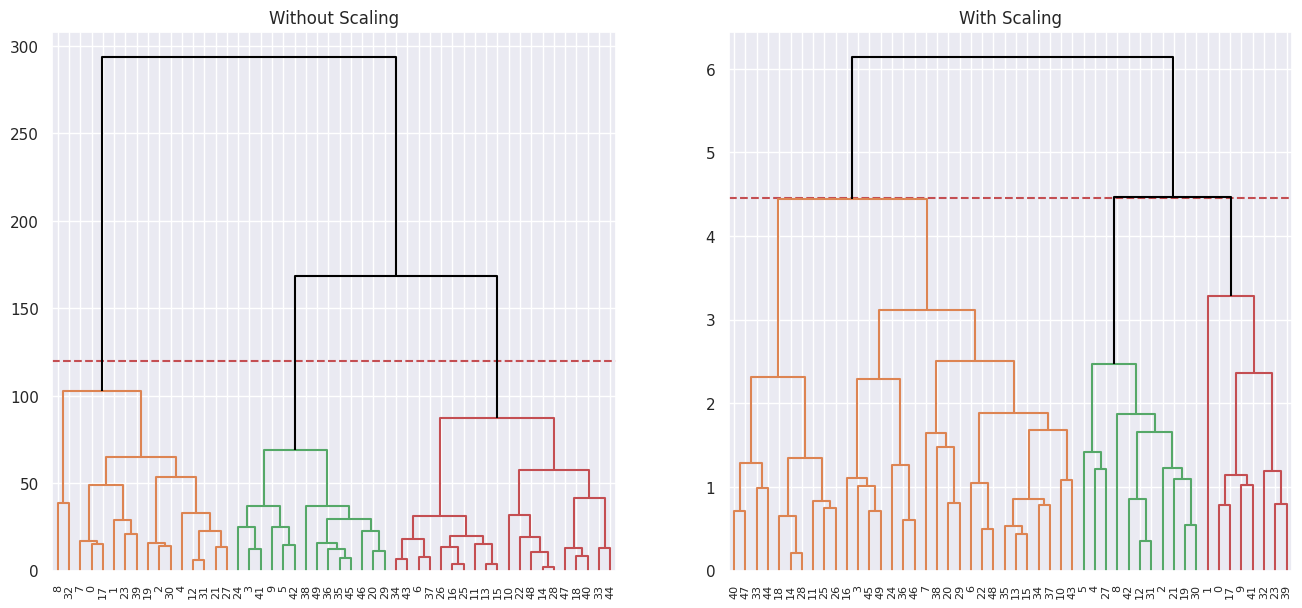

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].set_title("Without Scaling")
ax[0].axhline(120, c="r", ls="--")
dendrogram(linkage_comp, ax=ax[0], color_threshold=120, above_threshold_color="black")
ax[1].set_title("With Scaling")
ax[1].axhline(4.45, c="r", ls="--")
dendrogram(
    linkage_comp_scaled, ax=ax[1], color_threshold=4.45, above_threshold_color="black"
);


**(d)**

Scaling the variables results in a more reasonable hierarchical structure.

Yes I think it's necessary to scale variables in this case as the variables have different units. And since the clustering algorithm uses Euclidean distances as a measure of similarity, having non-standardized variables means that variables with bigger numbers (due to the difference in units) drive the clustering procedure. 

### **Q10.** 


**(a)** We'll draw $60$ observations and $50$ variables that follow the distribution:

$$
X \sim \mathcal{N}(0, 15^2)
$$

In [50]:
rng = np.random.default_rng(42)
X = rng.normal(size=60 * 50, scale=15).reshape(60, 50)
X.shape

(60, 50)

Generating the $3$ class labels:

In [51]:
rng = np.random.default_rng(42)
classes = rng.choice(np.arange(3).repeat(20), size=60, replace=False)
classes

array([0, 1, 0, 0, 1, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 2, 0, 0, 0,
       2, 0, 1, 0, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 0, 2,
       1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 2, 2, 2])

Applying a mean shift to each of the classes:

In [52]:
X[classes == 0] += 8
X[classes == 1] -= 12
X[classes == 2] -= 2
X.mean(), X.std()

(-2.3828435047151784, 17.514803933091343)

**(b)** Fitting `PCA`:

In [53]:
pca = PCA()
pca.fit(X)

PCA()

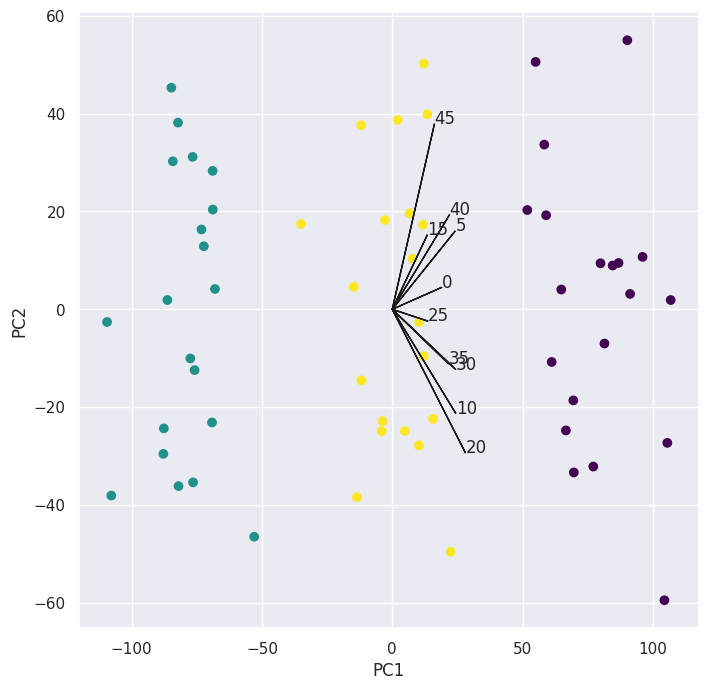

In [54]:
scores = pca.transform(X)

scale_arrow = s_ = 150
i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=classes, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))
for k in range(0, pca.components_.shape[1], 5):
    ax.arrow(0, 0, s_ * pca.components_[i, k], s_ * pca.components_[j, k], color="k")
    ax.text(s_ * pca.components_[i, k], s_ * pca.components_[j, k], str(k))


Note: I only plotted every fifth loading vector as plotting all of them gets messy.

We can see clear separation between the $3$ classes so we'll continue to the next part.

**(c)**


col_0,0,1,2
row_0,,,
0,20,0,0
1,0,20,0
2,0,0,20


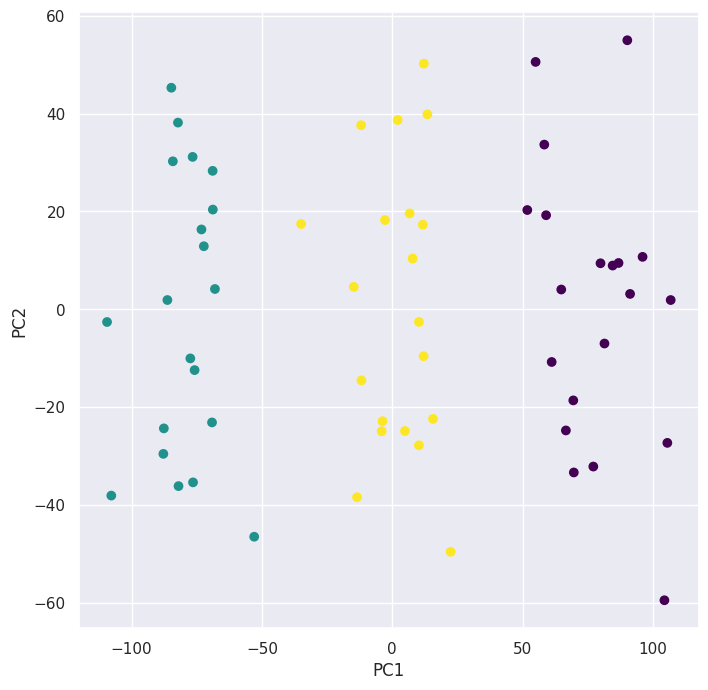

In [55]:
kmeans = KMeans(n_clusters=3, n_init=20, random_state=5)
preds = kmeans.fit_predict(X)

scale_arrow = s_ = 300
i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=preds, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))

pd.crosstab(preds, classes)

We can see that the algorithm perfectly grouped the observations.

**(d)**


col_0,0,1,2
row_0,,,
0,20,0,19
1,0,20,1


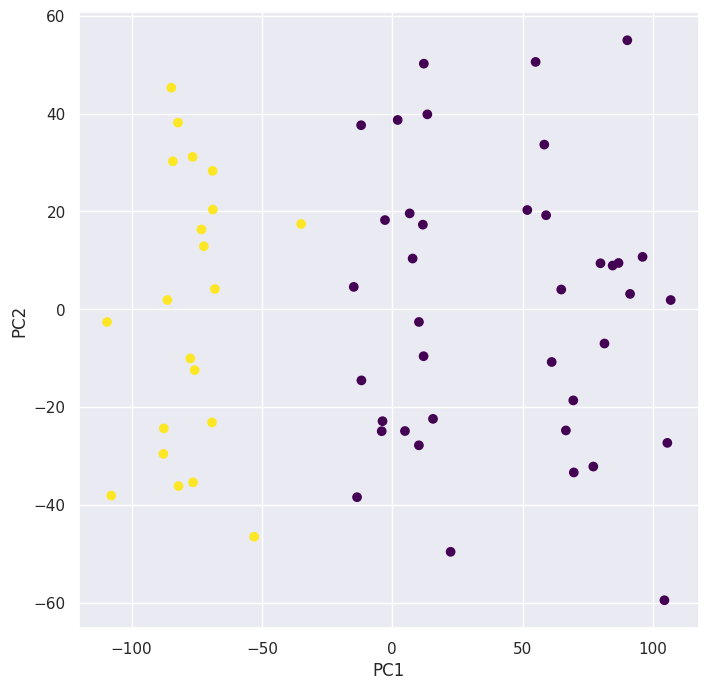

In [56]:
kmeans = KMeans(n_clusters=2, n_init=20, random_state=5)
preds = kmeans.fit_predict(X)

i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=preds, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))

pd.crosstab(preds, classes)

Plotting the new clustering with $K = 2$ using the principal component scores we can see that the algorithm combined the $2$ clusters on the right since they're closer to eachother.

**(e)**


col_0,0,1,2
row_0,,,
0,0,8,0
1,20,0,0
2,0,12,0
3,0,0,20


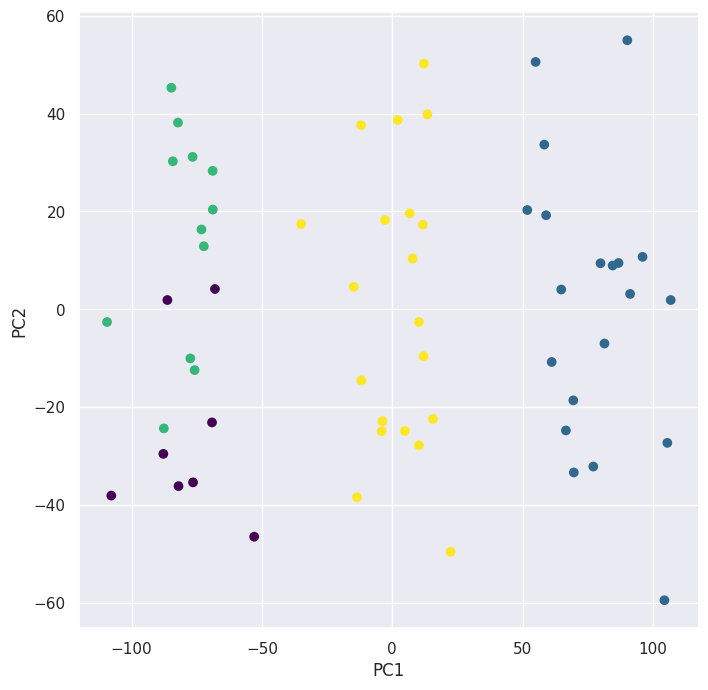

In [57]:
kmeans = KMeans(n_clusters=4, n_init=20, random_state=5)
preds = kmeans.fit_predict(X)

i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=preds, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))

pd.crosstab(preds, classes)

Looking at table made by `pd.crosstab()` and the biplot for $K = 4$ we can see that the algorithm split one of the clusters into $2$ clusters. 

**(f)** Performing $K$-means clustering with $K = 3$ on the first two principal component score vectors:

In [58]:
scores[:, :2].shape

(60, 2)

col_0,0,1,2
row_0,,,
0,0,0,20
1,20,0,0
2,0,20,0


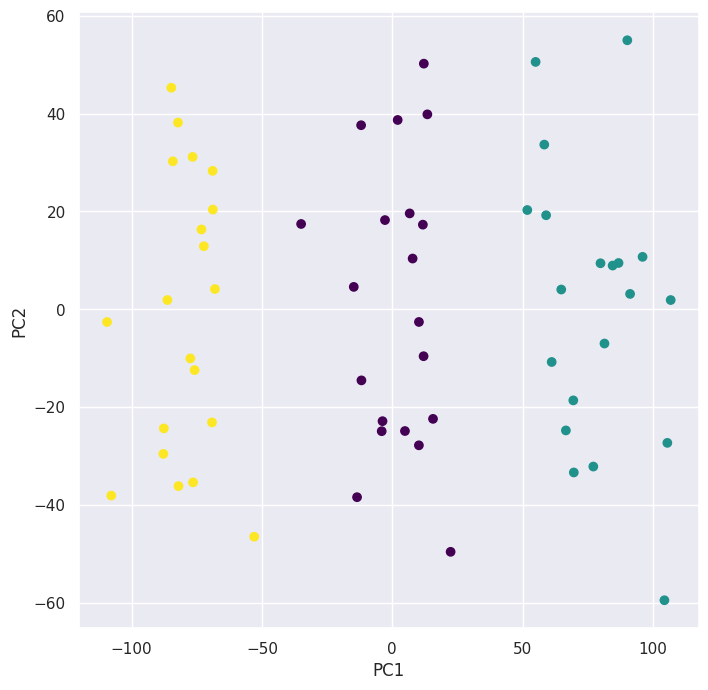

In [59]:
kmeans = KMeans(n_clusters=3, n_init=20, random_state=5)
preds = kmeans.fit_predict(scores[:, :2])

i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=preds, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))

pd.crosstab(preds, classes)

We can see that it successfully clustered the observations.

**(g)**

In [60]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)
pca = PCA()
scores_scaled = pca.fit_transform(X_scaled)

col_0,0,1,2
row_0,,,
0,20,0,0
1,0,20,1
2,0,0,19


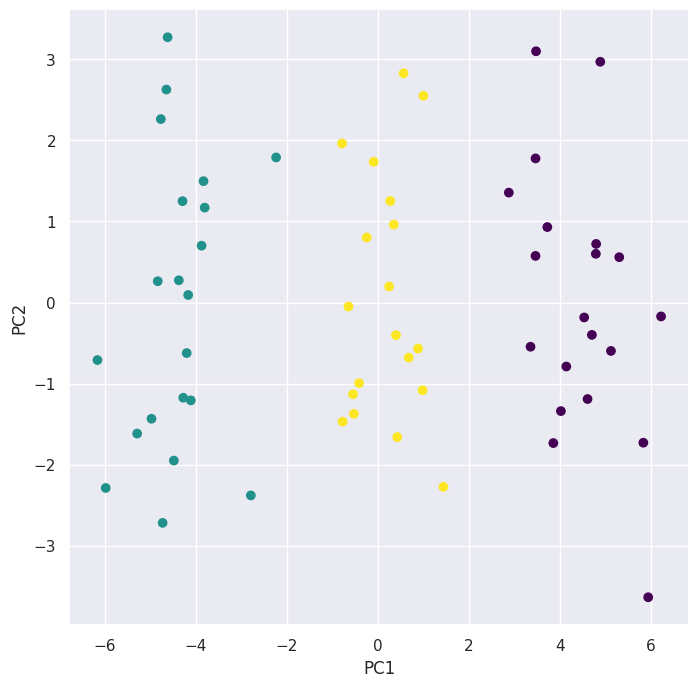

In [61]:
kmeans = KMeans(n_clusters=3, n_init=20, random_state=5)
preds = kmeans.fit_predict(X_scaled)

i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores_scaled[:, 0], scores_scaled[:, 1], c=preds, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))

pd.crosstab(preds, classes)

The clusters obtained using $K$-means clustering after scaling the data strongly aligns with the true underlying clusters when plotted using the first $2$ principal components. The reason is that there's clear separation in the first principal component direction and the $K$-means clustering algorithm seems to pick up on that.

### **Q11.** 

We'll use a similar implementation to the one used in the lab but with slight changes, instead of using `svd()` and the `low_rank()` approximation, I instead use `PCA()` to approximate the matrix. 

Note: I solved question **Q12** first and reused the PCA-based Algorithm $12.1$ implementation I used there.

In [62]:
def pca_approximation(X, M=1):
    pca = PCA()
    pca.fit(X)
    scores = pca.transform(X)
    return (scores[:, :M]).dot(pca.components_[:M])


def complete_matrix(
    X, n_componenets=1, max_iter=100, rel_err_thresh=1e-7, show_progrss=True
):
    # Create Xhat first and fill nan with column means
    Xhat = X.copy()
    Xbar = np.nanmean(Xhat, axis=0)
    nan_indices = np.where(np.isnan(Xhat))
    Xhat[nan_indices] = np.take(Xbar, nan_indices[1])

    # iterate until error stops decreasing
    rel_err = 1
    count = 0
    is_missing = np.isnan(X)
    mssold = np.mean(Xhat[~is_missing] ** 2)
    mss0 = np.mean(X[~is_missing] ** 2)
    while rel_err > rel_err_thresh and count < max_iter:
        count += 1
        # Step 2(a)
        Xapp = pca_approximation(Xhat, M=n_componenets)

        # Step 2(b)
        Xhat[is_missing] = Xapp[is_missing]

        # Step 2(c)
        mss = np.mean(((X - Xapp)[~is_missing]) ** 2)
        rel_err = (mssold - mss) / mss0
        mssold = mss
        if show_progrss:
            print(f"Iteration: {count}, MSS:{mss:.3f}, Rel.Err {rel_err:.2e}")

    return Xhat

To create the increasing and nested omits we'll start by creating two functions one that returns an array of all indices shuffled and another that takes the original matrix `X`, the `shuffled_indices`, and the `fraction_missing` then returns a matrix with those indices replaced by `np.nan`.

In [63]:
# Generate all possible (row, column) indices and shuffle them
def get_shuffled_indices(X, seed=42):
    rows, cols = np.indices(X.shape)
    all_indices = np.stack((rows.ravel(), cols.ravel()), axis=-1)

    rng = np.random.default_rng(seed)
    rng.shuffle(all_indices)
    return all_indices

In [64]:
def omit_nested(
    X: np.ndarray, shuffled_indices: np.ndarray, fraction_missing: float
) -> np.ndarray:
    if not 0.0 <= fraction_missing <= 1.0:
        raise ValueError("leave_out_percent must be between 0.0 and 1.0.")

    # Calculate the number of elements to omit
    n_omit = int(fraction_missing * X.size)

    Xna = X.copy()

    if n_omit == 0:
        return Xna

    # Select the first 'n_omit' indices from the shuffled list
    indices_to_omit = shuffled_indices[:n_omit]

    # Set the indices to nan
    # This requires transposing the indices to get separate row/col arrays
    Xna[tuple(indices_to_omit.T)] = np.nan

    return Xna

Now we'll load the `Boston` data set and scale it to zero mean and unit variance.

In [65]:
boston = load_data("Boston")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [66]:
boston_scaled = StandardScaler().fit_transform(boston)
boston_scaled.mean(), boston_scaled.std()

(-1.4852481934784703e-16, 1.0)

In [67]:
X = boston_scaled

Now we run the experiment for $10$ repetitions with values of `fractions_missing` from $5\%$ to $30\%$ in steps of $5\%$, and $M = 1,2, ..., 8$, then average those ten repetitions.

In [68]:
from tqdm import tqdm

seed = 42
repetitions = 10
fractions_missing = np.round(np.linspace(0.05, 0.3, 6), 2)
M_values = np.arange(1, 9)

results = []
mse = np.inf
for rep in tqdm(range(repetitions), desc="Reptition"):
    shuffled_indices = get_shuffled_indices(X, seed=seed)

    for fraction_missing in fractions_missing:
        Xna = omit_nested(
            X, shuffled_indices=shuffled_indices, fraction_missing=fraction_missing
        )
        is_missing = np.isnan(Xna)

        for M in M_values:
            Xhat = complete_matrix(
                Xna,
                n_componenets=M,
                max_iter=100,
                rel_err_thresh=1e-7,
                show_progrss=False,
            )

            true_values = X[is_missing]
            imputed_values = Xhat[is_missing]
            error = np.mean((true_values - imputed_values) ** 2)
            results.append(
                {"fraction_missing": fraction_missing, "M": M, "error": error}
            )

results_df = pd.DataFrame(results)
final_errors = (
    results_df.groupby(["fraction_missing", "M"])["error"].mean().reset_index()
)

Reptition: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


After running the experiments, our final error matrix looks like this:

In [69]:
err_matrix = final_errors.pivot(index="fraction_missing", columns="M", values="error")
err_matrix

M,1,2,3,4,5,6,7,8
fraction_missing,,,,,,,,
0.05,0.555639,0.503454,0.479305,1.187767,1.736788,1.555339,1.534037,1.635185
0.10,0.590802,0.516596,0.512056,1.109782,1.760655,2.002166,1.592197,2.103319
0.15,0.685400,0.604306,0.584111,0.872208,1.645621,1.867938,1.756951,1.787566
0.20,0.659219,0.581393,0.579571,0.937238,1.395288,1.833843,1.784812,1.588341
0.25,0.653214,0.594067,0.602807,0.882850,1.372548,1.846644,1.777403,1.742587
0.30,0.643075,0.617780,0.635888,1.015357,1.490215,1.656734,1.475871,1.510738


We'll plot it using a heatmap and a lineplot to better see how error varies along `fractions_missing` and `M`:

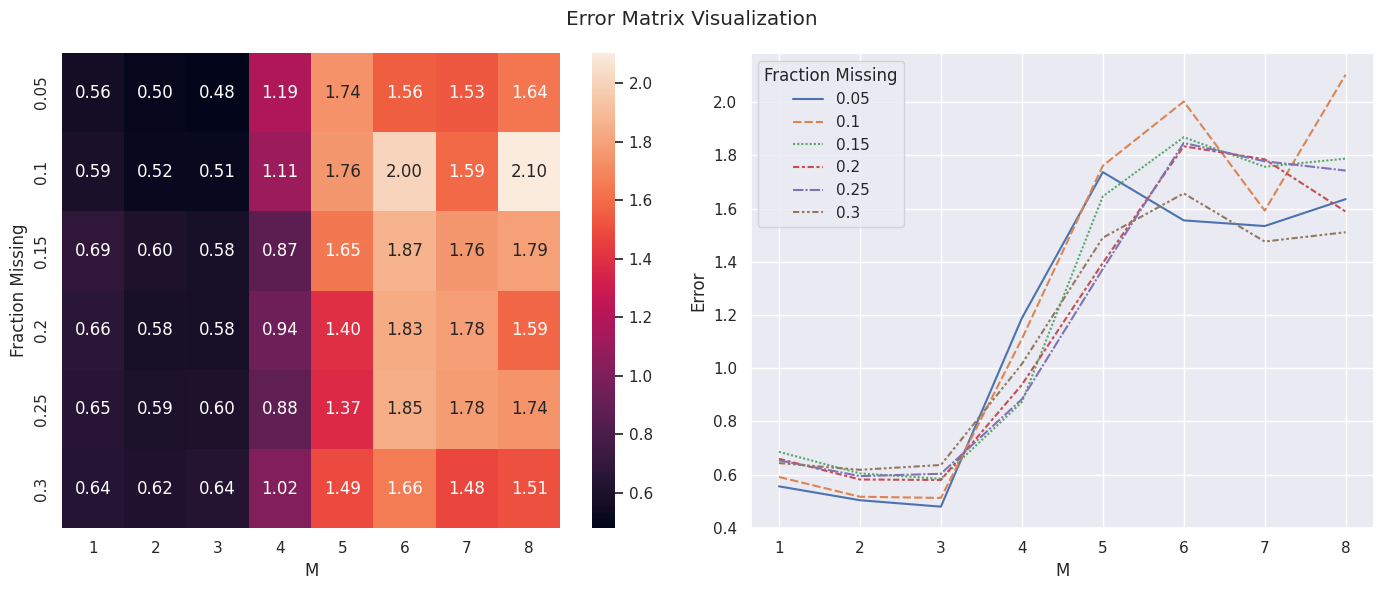

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(err_matrix, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_xlabel("M")
axes[0].set_ylabel("Fraction Missing")

sns.lineplot(err_matrix.T, ax=axes[1])
axes[1].set_xlabel("M")
axes[1].set_ylabel("Error")
axes[1].legend(title="Fraction Missing")

plt.suptitle("Error Matrix Visualization")
plt.tight_layout();

We can see that the approximation error is minimized around $M = 3$ then rapidly increases after, which hints at the first few principal components capturing most of the useful information in the data and the rest likely capturing noise.

We can also see that on average the error is smaller for smaller missing fractions, which is to be expected as the algorithm would have less data to work with if a bigger percentage of the matrix is missing. 

### **Q12.**  
Matrix completion using algorithm $(12.1)$ implemented using `PCA`.

Following section $(12.5.2)$, We'll apply this to the `USArrests` data set:

In [71]:
X = USArrests_scaled
X.shape

(50, 4)

We'll reuse the code that was used in the lab by omitting one of the $4$ variables for $20$ states picked at random:

In [72]:
n_omit = 20
np.random.seed(15)
r_idx = np.random.choice(np.arange(X.shape[0]), n_omit, replace=False)
c_idx = np.random.choice(np.arange(X.shape[1]), n_omit, replace=True)
Xna = X.copy()
Xna[r_idx, c_idx] = np.nan

#### Algorithm 12.1

Step 1: We create $\tilde X$ which is the matrix we want to complete with `nan` values (not observed) replaced with column means just like the lab.

In [73]:
Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0)
Xhat[r_idx, c_idx] = Xbar[c_idx]

Step 2: We apply the three steps $(a)-(c)$ in the algorithm $(12.1: \text{Page}. 517)$ iteratively until the objective function stops decreasing.

To implement step 2 of the algorithm with `PCA()` instead of `svd()` we only have to change the code for the `low_rank()` function used in the lab, to use `PCA()` to create the approximation matrix.

In [74]:
def pca_approximation(X, M=1):
    pca = PCA()
    pca.fit(X)
    scores = pca.transform(X)
    return (scores[:, :M]).dot(pca.components_[:M])

In [75]:
thresh = 1e-7
rel_err = 1
count = 0
is_missing = np.isnan(Xna)
mssold = np.mean(Xhat[~is_missing] ** 2)
mss0 = np.mean(Xna[~is_missing] ** 2)

In [76]:
while rel_err > thresh:
    count += 1
    # Step 2(a)
    Xapp = pca_approximation(Xhat, M=1)
    # Step 2(b)
    Xhat[is_missing] = Xapp[is_missing]
    # Step 2(c)
    mss = np.mean(((Xna - Xapp)[~is_missing]) ** 2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}".format(count, mss, rel_err))


Iteration: 1, MSS:0.395, Rel.Err 5.99e-01
Iteration: 2, MSS:0.382, Rel.Err 1.27e-02
Iteration: 3, MSS:0.381, Rel.Err 1.18e-03
Iteration: 4, MSS:0.381, Rel.Err 1.34e-04
Iteration: 5, MSS:0.381, Rel.Err 1.82e-05
Iteration: 6, MSS:0.381, Rel.Err 2.84e-06
Iteration: 7, MSS:0.381, Rel.Err 4.94e-07
Iteration: 8, MSS:0.381, Rel.Err 9.18e-08


We can see that after $8$ iterations the algorithm converged and got down to an $MSS$ of $0.381$, which is the same as that obtained in the lab using `svd()`.

And finally we compute the correlation between the $20$ imputed and original values:

In [77]:
np.corrcoef(Xapp[is_missing], X[is_missing])[0, 1]

0.7112159637495138

### **Q13.** 

**(a)** 

In [ ]:
genes = pd.read_csv("./data/Ch12Ex13.csv", header=None).T
genes.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.961933,-0.292526,0.258788,-1.152132,0.195783,0.030124,0.085418,1.116610,-1.218857,1.267369,...,1.325041,-0.116171,-1.470146,-0.379272,-1.465006,1.075148,-1.226125,-3.056328,1.450658,0.717977
1,0.441803,-1.139267,-0.972845,-2.213168,0.593306,-0.691014,-1.113054,1.341700,-1.277279,-0.918349,...,0.740838,-0.162392,-0.633375,-0.895521,2.034465,3.003267,-0.501702,0.449889,1.310348,0.763482
2,-0.975005,0.195837,0.588486,-0.861525,0.282992,-0.403426,-0.677969,0.103278,-0.558925,-1.253500,...,-0.435533,-0.235912,1.446660,-1.127459,0.440849,-0.123441,-0.717430,1.880362,0.383837,0.313576
3,1.417504,-1.281121,-0.800258,0.630925,0.247147,-0.729859,-0.562929,0.390963,-1.344493,-1.067114,...,-3.065529,1.597294,0.737478,-0.631248,-0.530442,-1.036740,-0.169113,-0.742841,-0.408860,-0.326473
4,0.818815,-0.251439,-1.820398,0.951772,1.978668,-0.364099,0.938194,-1.927491,1.159115,-0.240638,...,-2.378938,-0.086946,-0.122342,1.418029,1.075337,-1.270604,0.599530,2.238346,-0.471111,-0.158700


In [79]:
genes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 39
Columns: 1000 entries, 0 to 999
dtypes: float64(1000)
memory usage: 312.8 KB


**(b)** Applying hierarchical clustering with correlation-based distance using $3$ types of linkage and plotting the dendrograms for each then cutting at a height to get $2$ clusters without scaling:

Note: The question didn't specifiy whether to scale the data or not but it's necessary to get good results here so I do this twice once without and once with scaling to show how both affect the clustering procedure.

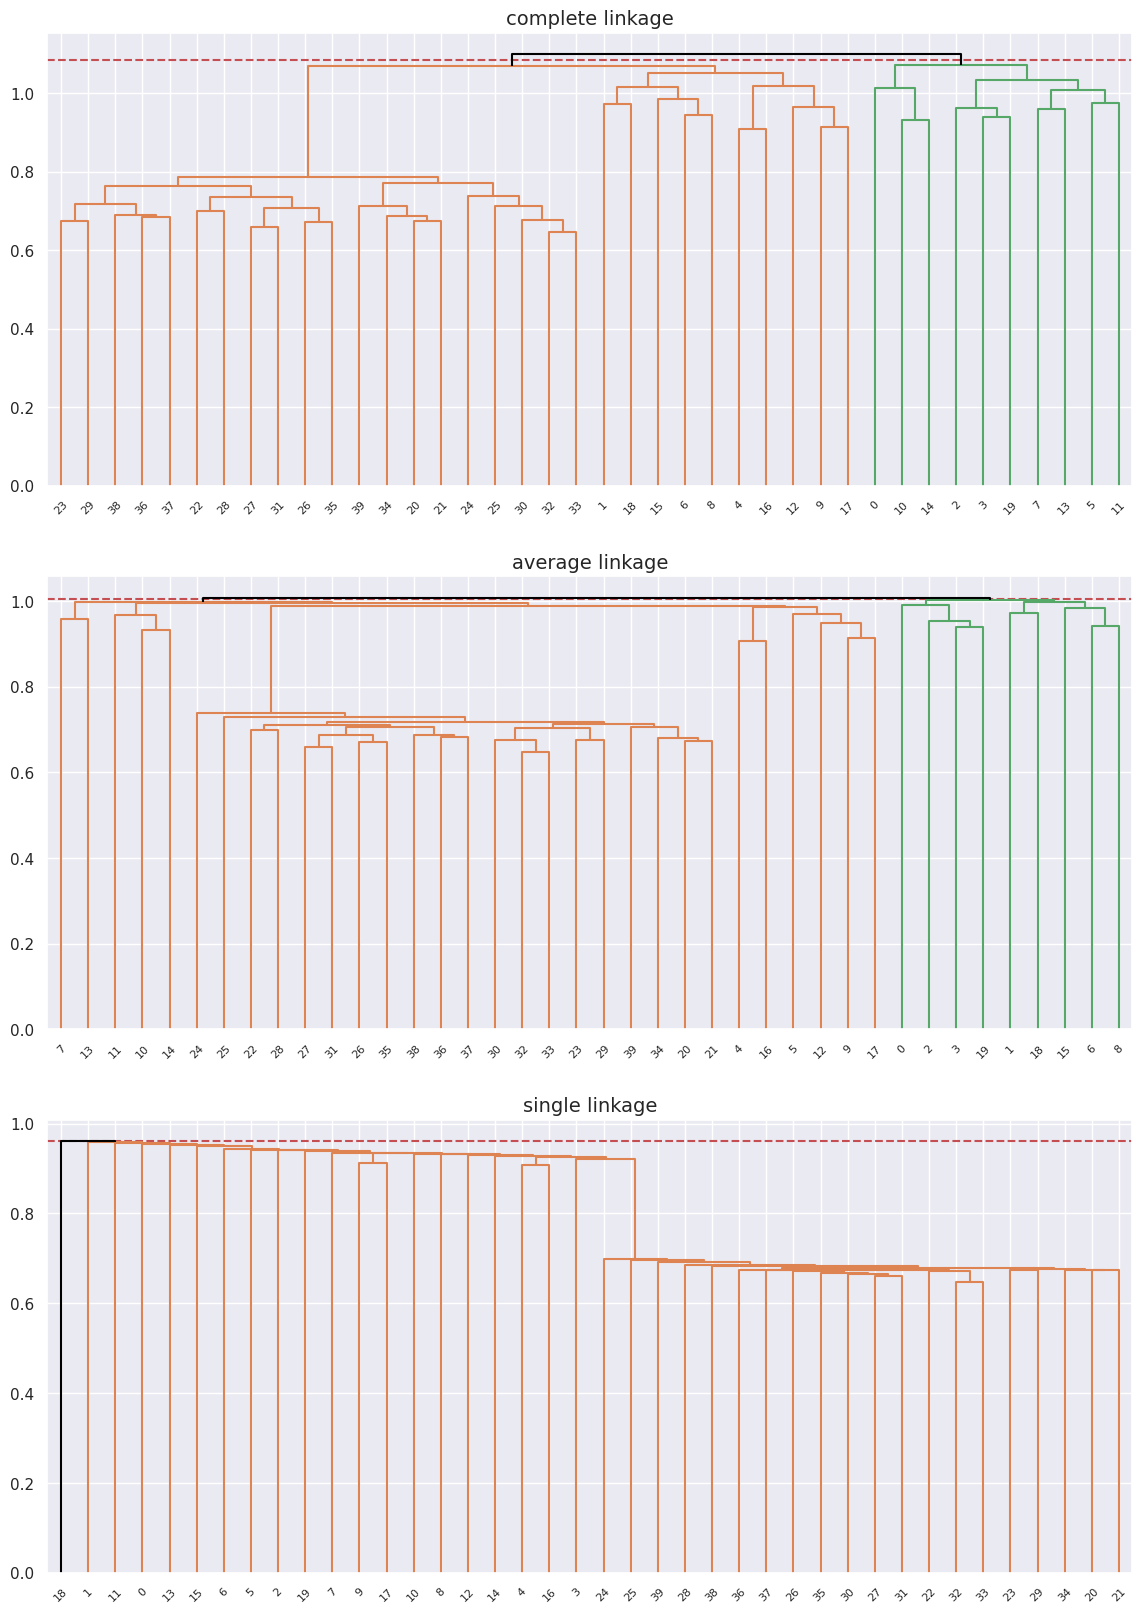

In [80]:
n_clusters = 2
metric = "correlation"

fig, axes = plt.subplots(3, 1, figsize=(14, 20))
axes = axes.flatten()
for ax, linkage in zip(axes, ["complete", "average", "single"]):
    hclust = AgglomerativeClustering(
        n_clusters=None, metric=metric, linkage=linkage, distance_threshold=0
    )
    hclust.fit(genes)
    linkage_comp = compute_linkage(hclust)

    distances = hclust.distances_

    cut_height = (distances[-(n_clusters - 1)] + distances[-n_clusters]) / 2
    ax.axhline(cut_height, c="r", ls="--")
    dendrogram(
        linkage_comp, ax=ax, color_threshold=cut_height, above_threshold_color="black"
    )
    ax.set_title(f"{linkage} linkage", fontsize=14)

The data separates into two groups in the cases of `complete` and `average` linkage though it doesn't perfectly separate the into the two original healthy and diseased groups, for the case of `complete` linkage it's pretty close, but pretty far off for `average` and completley off for `single` linkage.

Now scaling the data and attemtping the clustering again:

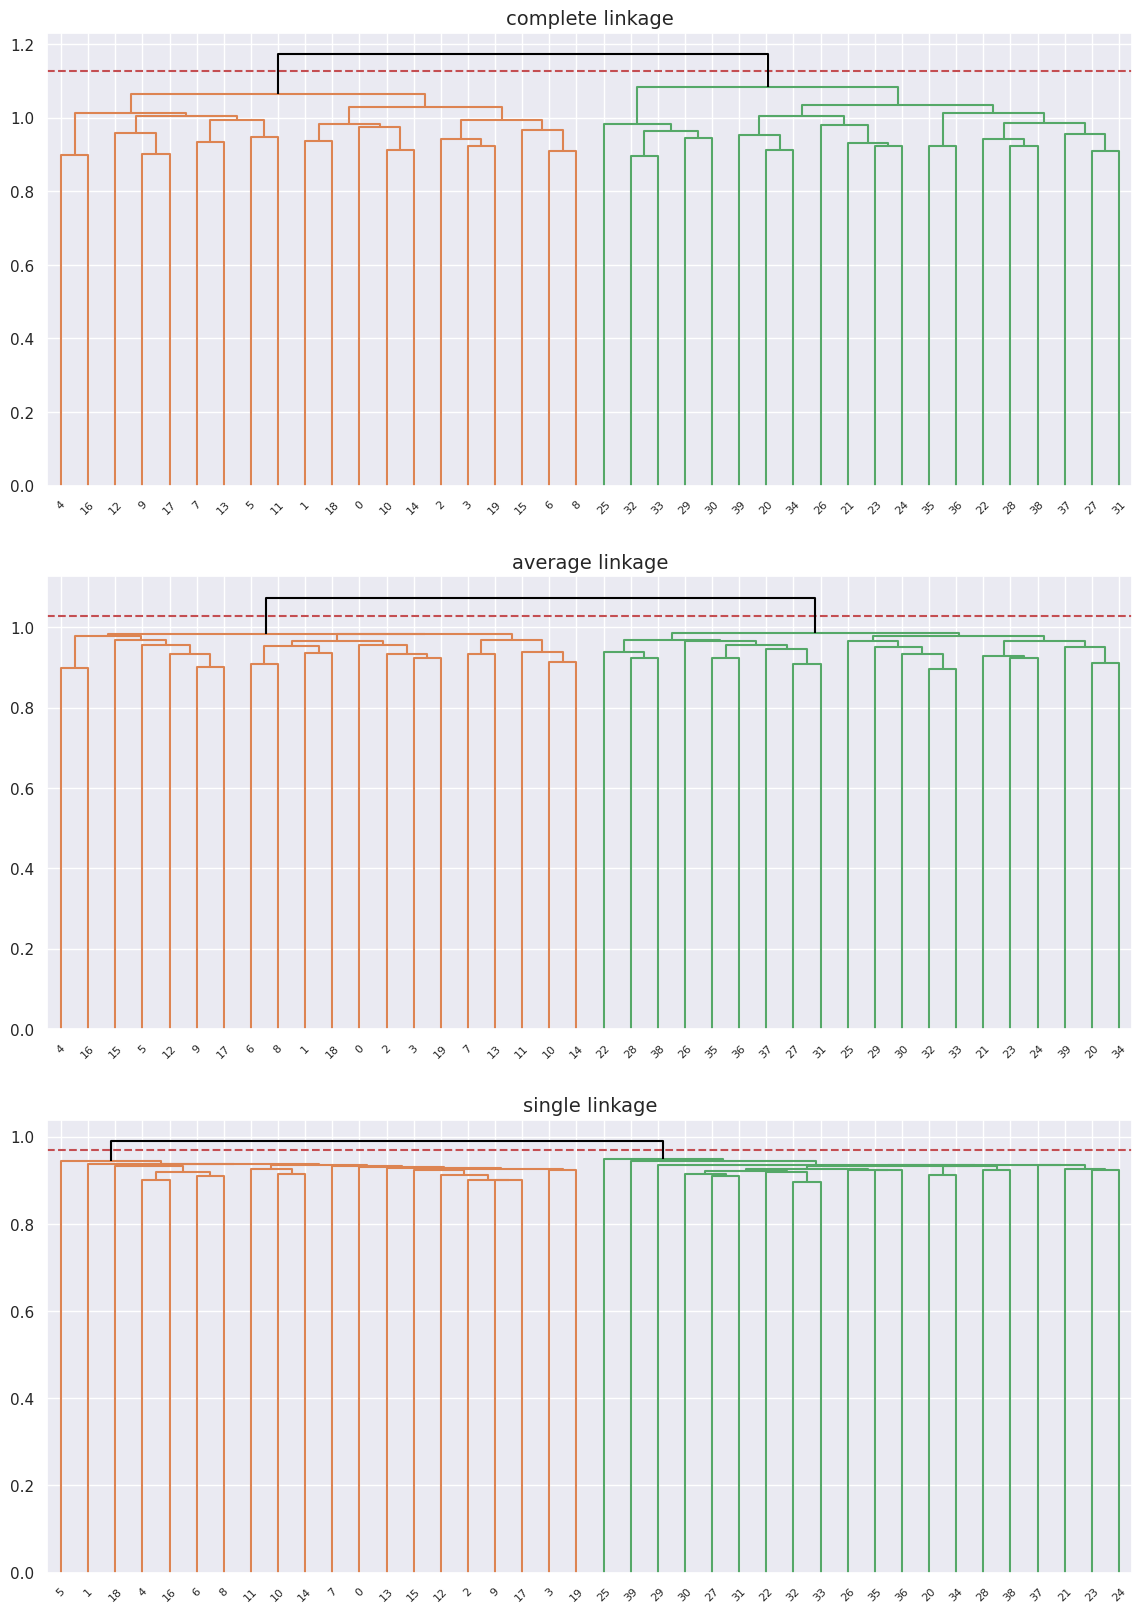

In [81]:
n_clusters = 2
metric = "correlation"

fig, axes = plt.subplots(3, 1, figsize=(14, 20))
axes = axes.flatten()

scaler = StandardScaler()
genes_scaled = scaler.fit_transform(genes)
for ax, linkage in zip(axes, ["complete", "average", "single"]):
    hclust = AgglomerativeClustering(
        n_clusters=None, metric=metric, linkage=linkage, distance_threshold=0
    )
    hclust.fit(genes_scaled)
    linkage_comp = compute_linkage(hclust)

    distances = hclust.distances_

    cut_height = (distances[-(n_clusters - 1)] + distances[-n_clusters]) / 2
    ax.axhline(cut_height, c="r", ls="--")
    dendrogram(
        linkage_comp, ax=ax, color_threshold=cut_height, above_threshold_color="black"
    )
    ax.set_title(f"{linkage} linkage", fontsize=14)

We can see that we get perfect separation here with clearly defined clusters regardless of the linkage type, and looking at the labels they match the original groups of healthy $[0-19]$ and diseased $[20-39]$ patients.

**(c)** An appropriate method to find out which genes differ the most across the two groups would be to perform `PCA` and inspect the loading vectors of the first principal component to see which genes contribute the most to it if clear separation is visible.

In [82]:
scaler = StandardScaler()
genes_scaled = scaler.fit_transform(genes)
pca = PCA()
pca.fit(genes_scaled)

PCA()

In [83]:
scores = pca.transform(genes_scaled)
scores.shape

(40, 40)

In [84]:
pca.components_.shape

(40, 1000)

I'll only plot the loadings of every 25th gene as to not get the plot super messy:

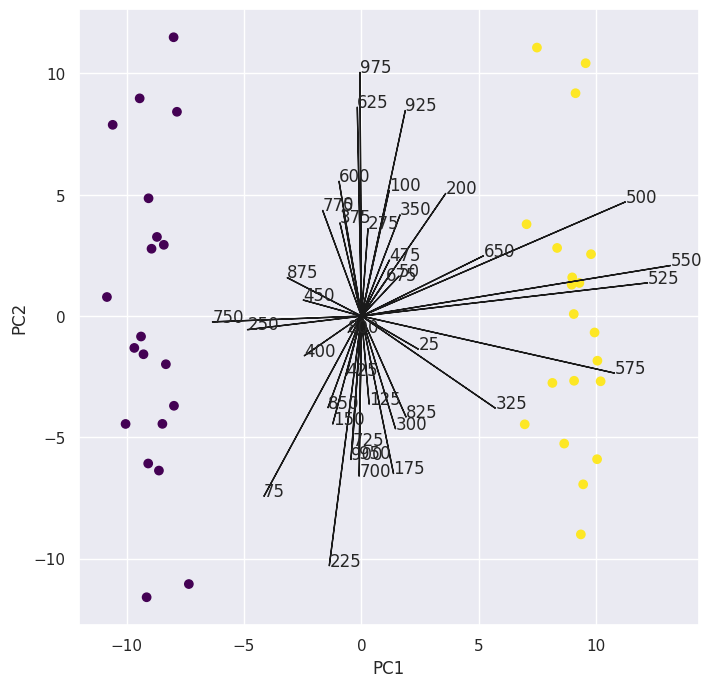

In [85]:
scale_arrow = s_ = 150
i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=[0] * 20 + [1] * 20, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))
for k in range(0, pca.components_.shape[1], 25):
    ax.arrow(0, 0, s_ * pca.components_[i, k], s_ * pca.components_[j, k], color="k")
    ax.text(s_ * pca.components_[i, k], s_ * pca.components_[j, k], str(k))


Now to pick the genes with the highest absolute loadings:

In [86]:
top_25_indices = np.argsort(np.abs(pca.components_[0]))[-50:]
top_25_indices

array([561, 515, 514, 525,  12, 538, 581, 548, 502, 504, 574,  15, 512,
       560,  14, 513, 568, 529, 558, 573, 557, 521, 519, 554, 587, 562,
       535, 547,  10, 553, 507, 539, 563, 565, 591, 527, 534, 598, 569,
       510, 508, 583, 537, 592, 550, 599, 589, 564, 588, 501])

I only picked the top $50$ out of the $1000$ arbitrarly. You can check however many loadings you want.

We can create another biplot using those $50$ loadings and as we expect they all strongly affect the first principal component and drive the separation between the classes.

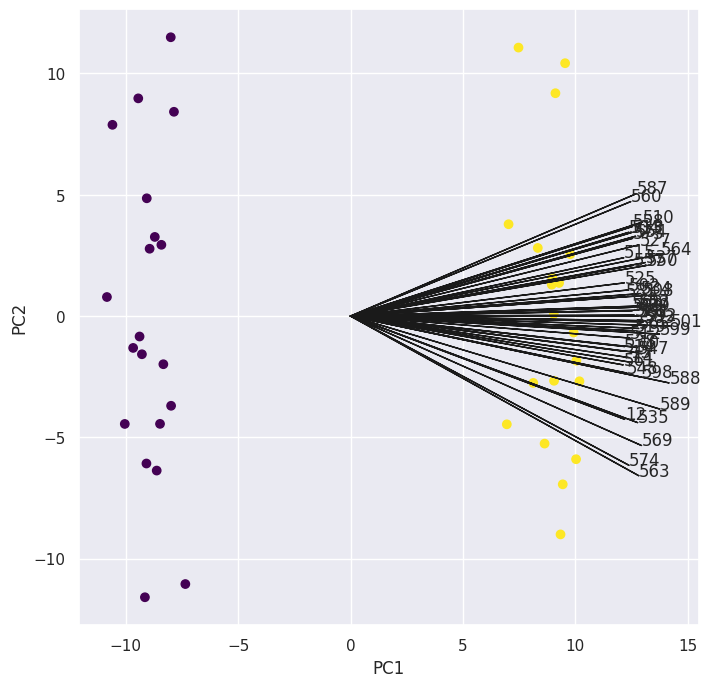

In [87]:
scale_arrow = s_ = 150
i, j = 0, 1  # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1], c=[0] * 20 + [1] * 20, cmap=plt.cm.viridis)
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))
for k in top_25_indices:
    ax.arrow(0, 0, s_ * pca.components_[i, k], s_ * pca.components_[j, k], color="k")
    ax.text(s_ * pca.components_[i, k], s_ * pca.components_[j, k], str(k))

To answer our "collaborator" here, I would pick those genes that have the highest absolute loadings in the first principal component, since them driving the separtion process means they're likely to differ the most across the two groups.